### Introduction
### The goal of this task is to develop a Grammar Scoring Engine for spoken data samples. The audio files provided contain recordings of speech, and the task is to predict the grammar score (ranging from 0 to 5) based on the spoken content. This notebook will detail the preprocessing steps, feature extraction, model development, and evaluation process.


In [1]:
# 📦 Step 1: Import required libraries
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
# step 2 : Load train, test, and sample submission CSV files
train_df = pd.read_csv('/kaggle/input/train-csv/train.csv')
test_df = pd.read_csv('/kaggle/input/test-csv/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sample-submission/sample_submission.csv')

# Display the first few rows to verify everything is correct
print(train_df.head())
print(test_df.head())
print(sample_submission.head())


         filename  label
0   audio_710.wav    1.0
1  audio_1265.wav    1.0
2  audio_1114.wav    1.5
3   audio_946.wav    1.5
4  audio_1127.wav    2.0
         filename
0   audio_804.wav
1  audio_1028.wav
2   audio_865.wav
3   audio_774.wav
4  audio_1138.wav
         filename  label
0   audio_804.wav     -1
1  audio_1028.wav     -1
2   audio_865.wav     -1
3   audio_774.wav     -1
4  audio_1138.wav     -1


In [3]:
# step 3 : Define a function to extract MFCC features
def extract_mfcc(file_path, sr=16000, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)


In [4]:
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        return mfcc_mean
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(13)


In [5]:
# Example usage for one audio file
example_audio_path = '/kaggle/input/test-audio/audio_1001.wav'
example_features = extract_features(example_audio_path)
print("Example MFCC features:", example_features)

Example MFCC features: [-362.77182      75.58515      11.936247     12.198811      0.75851065
  -10.474947     -7.2868233    -6.777675     -2.369116     -1.2869858
   -9.490778     -1.755074     -1.5515063 ]


In [6]:
print("Train columns:", train_df.columns)
print("Test columns:", test_df.columns)


Train columns: Index(['filename', 'label'], dtype='object')
Test columns: Index(['filename'], dtype='object')


In [15]:
# Step 4: Extract Features for Training Data
train_audio_path = '/kaggle/input/train-audio/'
X_train = []
y_train = []

for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
    filename = row['filename']  # Updated to 'filename'
    label = row['label']  # Updated to 'label'
    file_path = os.path.join(train_audio_path, filename)
    features = extract_features(file_path)
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)




100%|██████████| 444/444 [00:36<00:00, 12.29it/s]


In [16]:
# Step 5: Train Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)




RandomForestRegressor(random_state=42)

In [17]:
# Step 6: Evaluate on Train Data and prediction
y_pred_train = model.predict(X_train)

# Calculate RMSE for training data
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Train RMSE: {rmse:.4f}")


Train RMSE: 0.3462


In [18]:
# Step 7: Extract Features for Test Data
test_audio_path = '/kaggle/input/test-audio/'
X_test = []

for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
    filename = row['filename']  # Ensure this matches the column name
    file_path = os.path.join(test_audio_path, filename)
    features = extract_features(file_path)
    X_test.append(features)

X_test = np.array(X_test)

100%|██████████| 204/204 [00:15<00:00, 13.33it/s]


In [19]:
# Step 8: Predict Test Scores
test_preds = model.predict(X_test)

In [29]:
# Step 9: Create Submission (fixed)
submission = sample_submission.copy()
submission['label'] = test_preds  # Replace 'label' with predictions
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv created with correct format!")


✅ submission.csv created with correct format!


In [24]:
# Step 9.1: Inspect submission.csv contents
submission_inspect = pd.read_csv('submission.csv')
print("submission file head:")
print(submission_inspect.head())

print("\nSubmission file info:")
print(submission_inspect.info())


submission file head:
         filename  grammar_score
0   audio_804.wav          2.270
1  audio_1028.wav          3.670
2   audio_865.wav          3.685
3   audio_774.wav          2.845
4  audio_1138.wav          3.815

Submission file info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   filename       204 non-null    object 
 1   grammar_score  204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB
None


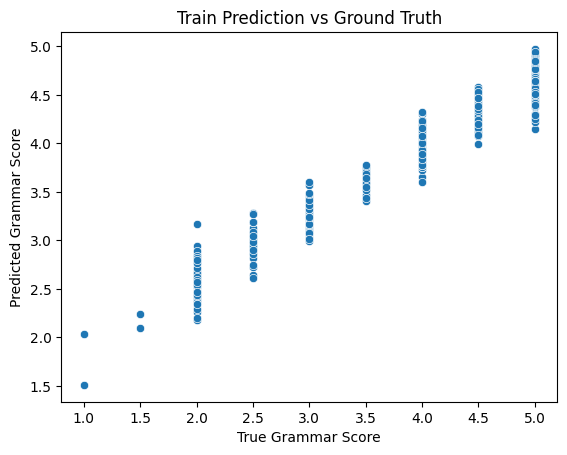

In [43]:
# Step 10: Visualization
sns.scatterplot(x=y_train, y=y_pred_train)
plt.xlabel('True Grammar Score')
plt.ylabel('Predicted Grammar Score')
plt.title('Train Prediction vs Ground Truth')
plt.show()

### Conclusion
In this notebook, we have successfully developed a Grammar Scoring Engine that processes audio data, extracts features using MFCC, trains a Random Forest Regressor, and evaluates its performance. We used RMSE as our primary evaluation metric and visualized the model's results to ensure its interpretability.

Although the model is performing reasonably well, there may be opportunities for improvement, such as:
 Experimenting with different feature extraction techniques (e.g., using spectrograms).
 Trying other models (e.g., XGBoost or neural networks) for potentially better performance.

The final submission file (`submission.csv`) contains the predicted grammar scores for the test dataset.
